In [1]:
#!pip install umap-learn

In [2]:
#!pip install xgboost catboost

In [3]:
#!pip install -U scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_A_events = pd.read_csv('../datasets/df_A_events.csv')
df_B_events = pd.read_csv('../datasets/df_B_events.csv')
df_C_events = pd.read_csv('../datasets/df_C_events.csv')
df_D_events = pd.read_csv('../datasets/df_D_events.csv')

csvs = [df_A_events, df_B_events, df_C_events, df_D_events]

In [6]:
for df in csvs:
    #TIME FEATURES
    df['Start time'] = pd.to_datetime(df['Start time'])
    df['End time'] = pd.to_datetime(df['End time'])
    df['Hour'] = df['Start time'].dt.hour
    df['Hour sin'] = np.sin(df['Hour'] * (2. * np.pi / 24))
    df['Hour cos'] = np.cos(df['Hour'] * (2. * np.pi / 24))
    df['Day of Week'] = df['Start time'].dt.dayofweek
    df['Duration'] = (df['End time'] - df['Start time']).dt.total_seconds()
    #events under 1 second would be 0 duration, so we set them to 0.5
    df.loc[df['Duration'] == 0, 'Duration'] = 0.5

    #DERIVED FEATURES
    df['Packet Rate'] = df['Packet speed'] / df['Duration']
    df['Data Rate'] = df['Data speed'] / df['Duration']
    df['Packet Size to Speed Ratio'] = df['Avg packet len'] / df['Packet speed']
    df['Data to Packet Ratio'] = df['Data speed'] / df['Packet speed']  

    #NORMALIZE
    df['Packet speed'] = (df['Packet speed'] - df['Packet speed'].min()) / (df['Packet speed'].max() - df['Packet speed'].min())
    df['Data speed'] = (df['Data speed'] - df['Data speed'].min()) / (df['Data speed'].max() - df['Data speed'].min())


feature_cols = ['Packet speed', 'Data speed', 'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio','Duration', 'Hour sin', 'Hour cos', 'Day of Week']


 

In [7]:
df_A_events[feature_cols].head()

,Packet speed,Data speed,Packet Rate,Data Rate,Packet Size to Speed Ratio,Data to Packet Ratio,Duration,Hour sin,Hour cos,Day of Week
0,0.012829,0.035732,55600.000000,73.000000,0.024874,0.001313,1.0,-1.0,-1.836970e-16,0
1,0.015076,0.044053,127000.000000,180.000000,0.023717,0.001417,0.5,-1.0,-1.836970e-16,0
2,0.014848,0.040137,62700.000000,82.000000,0.022313,0.001308,1.0,-1.0,-1.836970e-16,0
3,0.013938,0.041605,59500.000000,85.000000,0.024975,0.001429,1.0,-1.0,-1.836970e-16,0
4,0.019272,0.055311,1397.321429,2.017857,0.019399,0.001444,56.0,-1.0,-1.836970e-16,0


In [8]:
df_A_components = pd.read_csv('../datasets/df_A_components.csv')
df_B_components = pd.read_csv('../datasets/df_B_components.csv')
df_C_components = pd.read_csv('../datasets/df_C_components.csv')
df_D_components = pd.read_csv('../datasets/df_D_components.csv')

comp_csvs = [df_A_components, df_B_components, df_C_components, df_D_components]

In [9]:
for df, df_comp in zip(csvs, comp_csvs):
    unique_ports = df_comp.groupby('Attack ID')['Port number'].nunique()
    df['Unique ports']=df_comp['Attack ID'].map(unique_ports)
    
    std_packet_speed = df_comp.groupby('Attack ID')['Packet speed'].std(ddof=0)
    df['Std packet speed']=df_comp['Attack ID'].map(std_packet_speed)
    max_packet_speed = df_comp.groupby('Attack ID')['Packet speed'].max()
    df['Max packet speed']=df_comp['Attack ID'].map(max_packet_speed)
    
    std_data_speed = df_comp.groupby('Attack ID')['Data speed'].std(ddof=0)
    df['Std data speed']=df_comp['Attack ID'].map(std_data_speed)
    max_data_speed = df_comp.groupby('Attack ID')['Data speed'].max()
    df['Max data speed']=df_comp['Attack ID'].map(max_data_speed)
    
    std_packet_length = df_comp.groupby('Attack ID')['Avg packet len'].std(ddof=0)
    df['Std packet length']=df_comp['Attack ID'].map(std_packet_length)
    max_packet_length = df_comp.groupby('Attack ID')['Avg packet len'].max()
    df['Max packet length']=df_comp['Attack ID'].map(max_packet_length)

    std_source_ip_count= df_comp.groupby('Attack ID')['Source IP count'].std(ddof=0)
    df['Std source IP count']=df_comp['Attack ID'].map(std_source_ip_count)
    max_source_ip_count = df_comp.groupby('Attack ID')['Source IP count'].max()
    df['Max source IP count']=df_comp['Attack ID'].map(max_source_ip_count)

    df_comp['Time']=pd.to_datetime(df_comp['Time'])
    df_comp = df_comp.sort_values(by=["Attack ID", "Time"])
    df_comp["Time diff"] = df_comp.groupby("Attack ID")["Time"].diff().dt.total_seconds().fillna(0)
    time_diff_mean = df_comp.groupby("Attack ID")["Time diff"].mean()
    time_diff_std = df_comp.groupby("Attack ID")["Time diff"].std(ddof=0)
    df['Mean time diff'] = df_comp['Attack ID'].map(time_diff_mean)
    df['Std time diff'] = df_comp['Attack ID'].map(time_diff_std)

In [10]:
df_A_events.head()

,Unnamed: 0,Attack ID,Victim IP,Port number,Detect count,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,...,Std packet speed,Max packet speed,Std data speed,Max data speed,Std packet length,Max packet length,Std source IP count,Max source IP count,Mean time diff,Std time diff
0,0,1,IP_0001,4500,1,0.012829,0.035732,1383,6,2022-08-08 18:09:36,...,0.0,55600,0.0,73,0.0,1383,0.0,6,0.0,0.0
1,1,2,IP_0002,4500,1,0.015076,0.044053,1506,1,2022-08-08 18:37:28,...,0.0,63500,0.0,90,0.0,1506,0.0,1,0.0,0.0
2,2,3,IP_0003,1200,2,0.014848,0.040137,1399,1,2022-08-08 18:41:25,...,3000.0,65700,3.5,86,0.0,1399,0.0,1,0.5,0.5
3,3,4,IP_0002,4500,1,0.013938,0.041605,1486,1,2022-08-08 18:47:49,...,3000.0,65700,3.5,86,0.0,1399,0.0,1,0.5,0.5
4,4,5,IP_0004,12347,2,0.019272,0.055311,1518,1,2022-08-08 18:57:15,...,0.0,59500,0.0,85,0.0,1486,0.0,1,0.0,0.0


In [11]:
df_A_events['Unique ports'].value_counts()

Unique ports
1     66989
2     36704
3     10239
50     5300
4      3827
23     3226
5      2941
6      2484
54     1845
13      557
7       414
12      123
8       117
Name: count, dtype: int64

In [12]:
from umap.umap_ import UMAP
from sklearn.decomposition import PCA
import os

# Csak df_A_events-en futtatjuk
datasets_path = os.path.join('..', 'datasets')
df = df_A_events.copy()
train_df = pd.concat([df_A_events, df_B_events])
test_df = df_C_events
model_csvs = [train_df, test_df]

# Mintavételezés – csak 2000 sor
sample_df = df.sample(n=2000, random_state=42).reset_index(drop=True)

mymap = UMAP(random_state=42, n_components=2, n_neighbors=15) # jó ötletnek tűnt, de aztán meghalt a gépem
pca = PCA(n_components=2,random_state=42)

sample_df[['umap_1', 'umap_2']] = mymap.fit_transform(sample_df[feature_cols])

for df in csvs:
    #df['umap_1']=0
    #df['umap_2']=0
    #df[['umap_1','umap_2']]=mymap.fit_transform(df[feature_cols])       
    df['pca_1']=0
    df['pca_2']=0
    df[['pca_1','pca_2']]=pca.fit_transform(df[feature_cols])
for df in model_csvs:
    df['pca_1']=0
    df['pca_2']=0
    df[['pca_1','pca_2']]=pca.fit_transform(df[feature_cols])
train_df.to_csv(os.path.join(datasets_path, 'train_data.csv'), index=False)
test_df.to_csv(os.path.join(datasets_path, 'val_data.csv'), index=False)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [13]:
train_df.head()

,Unnamed: 0,Attack ID,Victim IP,Port number,Detect count,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,...,Std data speed,Max data speed,Std packet length,Max packet length,Std source IP count,Max source IP count,Mean time diff,Std time diff,pca_1,pca_2
0,0,1,IP_0001,4500,1,0.012829,0.035732,1383,6,2022-08-08 18:09:36,...,0.0,73,0.0,1383,0.0,6,0.0,0.0,5882.390147,-43.601836
1,1,2,IP_0002,4500,1,0.015076,0.044053,1506,1,2022-08-08 18:37:28,...,0.0,90,0.0,1506,0.0,1,0.0,0.0,77282.435588,23.576695
2,2,3,IP_0003,1200,2,0.014848,0.040137,1399,1,2022-08-08 18:41:25,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,12982.392646,-36.872210
3,3,4,IP_0002,4500,1,0.013938,0.041605,1486,1,2022-08-08 18:47:49,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,9782.400003,-39.903941
4,4,5,IP_0004,12347,2,0.019272,0.055311,1518,1,2022-08-08 18:57:15,...,0.0,85,0.0,1486,0.0,1,0.0,0.0,-48320.362374,-39.977475


# Tesztelés

In [14]:
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score
from sklearn.ensemble import RandomForestClassifier

In [15]:

A_X = df_A_events[feature_cols]
A_y = df_A_events['Type']

X_train, X_test, y_train, y_test = train_test_split(A_X, A_y, test_size=0.2, random_state=42, stratify=A_y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Pontosság:", accuracy_score(y_test, y_pred))
print("Konfúziós mátrix:\n", confusion_matrix(y_test, y_pred))
print("Osztályozási riport (Random Forest):")
print(classification_report(y_test, y_pred))

Pontosság: 0.930511241374193
Konfúziós mátrix:
 [[  118    51    16]
 [   11 24455   361]
 [    9  1425   508]]
Osztályozási riport (Random Forest):
                    precision    recall  f1-score   support

       DDoS attack       0.86      0.64      0.73       185
    Normal traffic       0.94      0.99      0.96     24827
Suspicious traffic       0.57      0.26      0.36      1942

          accuracy                           0.93     26954
         macro avg       0.79      0.63      0.68     26954
      weighted avg       0.92      0.93      0.92     26954



In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(A_y)

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

X_sample = A_X.sample(n=2000, random_state=42)
y_sample = y_encoded[X_sample.index]

# GT modellek összehasonlítása kereszvalidációval
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(eval_metric='mlogloss'),
    'CatBoost': CatBoostClassifier(verbose=0)
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_sample, y_sample, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name} CV pontosság: {scores.mean():.4f} ± {scores.std():.4f}")

Random Forest CV pontosság: 0.9300 ± 0.0019
SVM CV pontosság: 0.9265 ± 0.0001
kNN CV pontosság: 0.9225 ± 0.0031
XGBoost CV pontosság: 0.9250 ± 0.0021
CatBoost CV pontosság: 0.9255 ± 0.0007


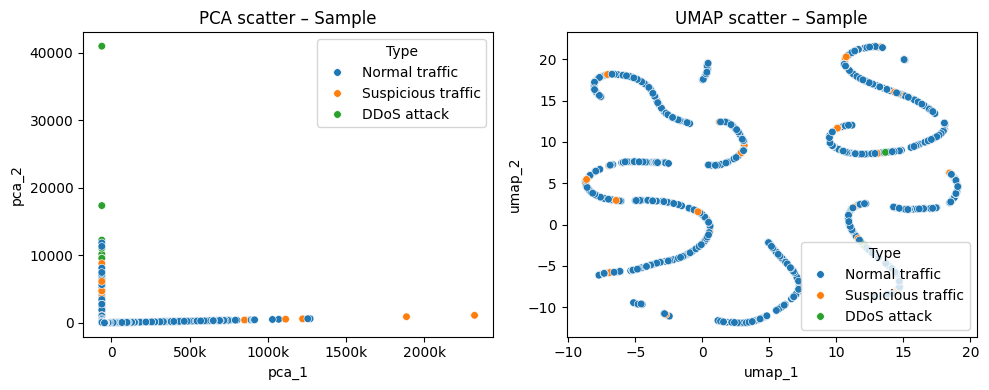

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def thousands_formatter(x, pos):
    return f"{int(x/1000)}k" if x >= 1000 else int(x)
    
# UMAP scatter plot csak minta alapján (sample_df)
if 'umap_1' in sample_df.columns and 'pca_1' in df_A_events.columns:
    plt.figure(figsize=(10, 4))

    ax1 = plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_A_events, x='pca_1', y='pca_2', hue='Type', palette='tab10', s=30)
    ax1.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))
    plt.title("PCA scatter – Sample")

    ax2 = plt.subplot(1, 2, 2)
    sns.scatterplot(data=sample_df, x='umap_1', y='umap_2', hue='Type', palette='tab10', s=30)
    plt.title("UMAP scatter – Sample")

    plt.tight_layout()
    plt.show()
else:
    print("A sample_df nem tartalmaz PCA/UMAP oszlopokat.")

In [19]:
A_X = df_A_events[feature_cols]
A_y = df_A_events['Type']
X_train, X_test, y_train, y_test = train_test_split(A_X, A_y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

recall = recall_score(y_test, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 93.17%
Recall: 63.50%
[[  131    47    20]
 [    8 24486   334]
 [    4  1428   496]]


In [20]:
feature_cols += ['Unique ports', 'Std packet speed', 'Max packet speed', 'Std data speed', 'Max data speed', 'Std packet length', 'Max packet length',
                  'Std source IP count', 'Max source IP count', 'Mean time diff', 'Std time diff']

In [21]:
A_X = df_A_events[feature_cols]
A_y = df_A_events['Type']
X_train, X_test, y_train, y_test = train_test_split(A_X, A_y, test_size=0.2, random_state=42)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
recall = recall_score(y_test, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 94.13%
Recall: 67.12%
[[  131    44    23]
 [    3 24539   286]
 [    4  1223   701]]


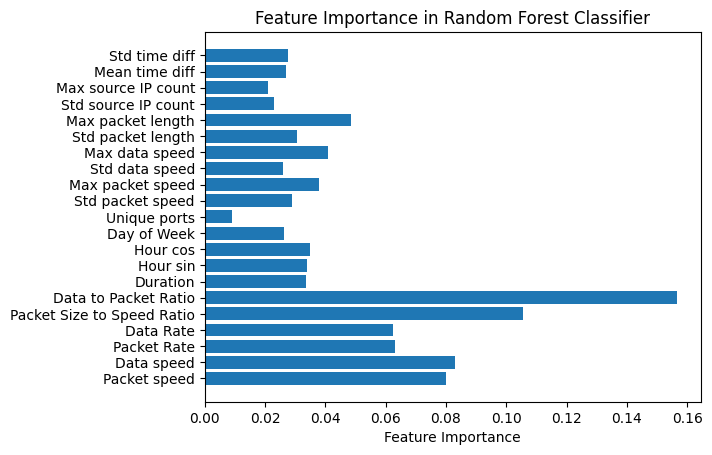

In [22]:
feature_importances = classifier.feature_importances_
plt.barh(feature_cols, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [23]:
feature_cols += ['pca_1','pca_2']

In [24]:
A_X = df_A_events[feature_cols]
A_y = df_A_events['Type']
X_train, X_test, y_train, y_test = train_test_split(A_X, A_y, test_size=0.2, random_state=42)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
recall = recall_score(y_test, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Accuracy: 94.10%
Recall: 66.32%
[[  128    44    26]
 [    5 24554   269]
 [    4  1241   683]]


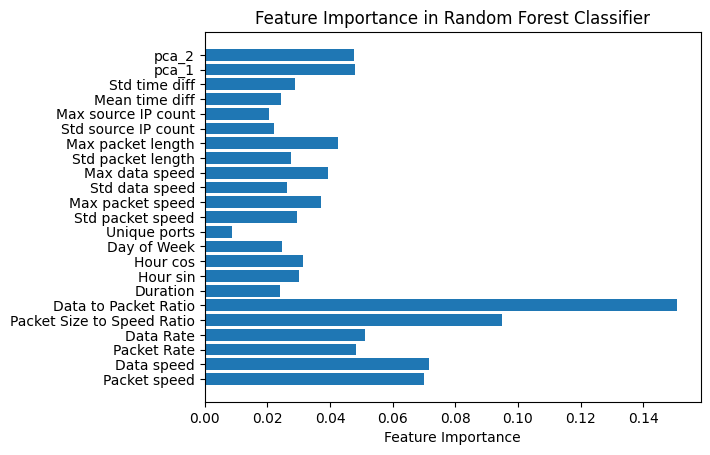

In [25]:
feature_importances = classifier.feature_importances_
plt.barh(feature_cols, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

In [26]:
#!pip install imblearn

In [27]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
brf = BalancedRandomForestClassifier(
    n_estimators=100, random_state=0, sampling_strategy="all", replacement=True,
    bootstrap=False,
)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)
balanced_accuracy_score=balanced_accuracy_score(y_test, y_pred)
print(f'Balanced accuracy: {balanced_accuracy_score * 100:.2f}%')
recall = recall_score(y_test, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

Balanced accuracy: 85.99%
Recall: 85.99%


In [28]:
from imblearn.over_sampling import SMOTE

# Create a SMOTE instance with a specific sampling strategy
# This will bring the DDoS attack class to exactly 3000 samples
smote = SMOTE(sampling_strategy={'Normal traffic': 124133, 
                                 'Suspicious traffic': 30000, 
                                 'DDoS attack': 3000}, 
              random_state=42)

# Perform the resampling
X_smote, y_smote = smote.fit_resample(A_X, A_y)

# Verify the new class distribution
print("Original class distribution:")
print(A_y.value_counts())
print("\nResampled class distribution:")
print(y_smote.value_counts())

# Continue with train-test split and model training
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

recall = recall_score(y_test, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Original class distribution:
Type
Normal traffic        124133
Suspicious traffic      9707
DDoS attack              926
Name: count, dtype: int64

Resampled class distribution:
Type
Normal traffic        124133
Suspicious traffic     30000
DDoS attack             3000
Name: count, dtype: int64
Accuracy: 94.24%
Recall: 85.92%
[[  485    92    43]
 [    9 24252   591]
 [    6  1069  4880]]


# Modellkészítés

In [29]:
train_df = pd.concat([df_A_events, df_B_events])
val_df = df_C_events
train_df.to_csv('train_data.csv', index=False)
val_df.to_csv('validation_data.csv', index=False)

In [30]:
train_df.head()

,Unnamed: 0,Attack ID,Victim IP,Port number,Detect count,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,...,Std data speed,Max data speed,Std packet length,Max packet length,Std source IP count,Max source IP count,Mean time diff,Std time diff,pca_1,pca_2
0,0,1,IP_0001,4500,1,0.012829,0.035732,1383,6,2022-08-08 18:09:36,...,0.0,73,0.0,1383,0.0,6,0.0,0.0,-5583.173430,-32.109090
1,1,2,IP_0002,4500,1,0.015076,0.044053,1506,1,2022-08-08 18:37:28,...,0.0,90,0.0,1506,0.0,1,0.0,0.0,65816.895936,1.023925
2,2,3,IP_0003,1200,2,0.014848,0.040137,1399,1,2022-08-08 18:41:25,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,1516.831470,-28.762497
3,3,4,IP_0002,4500,1,0.013938,0.041605,1486,1,2022-08-08 18:47:49,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,-1683.162247,-30.280003
4,4,5,IP_0004,12347,2,0.019272,0.055311,1518,1,2022-08-08 18:57:15,...,0.0,85,0.0,1486,0.0,1,0.0,0.0,-59785.918080,-2.654684


In [31]:
train_df['Type'].value_counts()

Type
Normal traffic        249013
Suspicious traffic     13380
DDoS attack             2373
Name: count, dtype: int64

In [32]:
val_df['Type'].value_counts()

Type
Normal traffic        125893
Suspicious traffic      3052
DDoS attack             1055
Name: count, dtype: int64

In [33]:
feature_cols_1=['Packet speed', 'Data speed', 'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio', 'Duration', 'Hour sin', 'Hour cos', 'Day of Week', 'Unique ports', 'Std packet speed', 'Max packet speed', 'Std data speed', 'Max data speed', 'Std packet length', 'Max packet length', 'Std source IP count', 'Max source IP count', 'Mean time diff', 'Std time diff', 'pca_1', 'pca_2']
feature_cols_2 = ['Data to Packet Ratio','Packet Size to Speed Ratio','Packet speed', 'Data speed', 'Packet Rate', 'Data Rate','pca_1', 'pca_2']

In [34]:
X = train_df[feature_cols_2]
y = train_df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train.value_counts()

Type
Normal traffic        199208
Suspicious traffic     10701
DDoS attack             1903
Name: count, dtype: int64

In [35]:

smote = SMOTE(sampling_strategy={'Normal traffic': 199208, 
                                 'Suspicious traffic': 50000, 
                                 'DDoS attack': 5000}, 
              random_state=42)

# Perform the resampling
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Verify the new class distribution
print("Original class distribution:")
print(y_train.value_counts())
print("\nResampled class distribution:")
print(y_smote.value_counts())

# Continue with train-test split and model training


classifier.fit(X_smote, y_smote)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

recall = recall_score(y_test, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

Original class distribution:
Type
Normal traffic        199208
Suspicious traffic     10701
DDoS attack             1903
Name: count, dtype: int64

Resampled class distribution:
Type
Normal traffic        199208
Suspicious traffic     50000
DDoS attack             5000
Name: count, dtype: int64
Accuracy: 94.91%
Recall: 76.76%
[[  350    96    24]
 [   60 48334  1411]
 [   19  1086  1574]]


In [36]:
X_train = train_df[feature_cols_2]
y_train = train_df['Type']
X_test = val_df[feature_cols_2]
y_test = val_df['Type']
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [37]:
pd.Series(y_train_encoded).value_counts()

1    249013
2     13380
0      2373
Name: count, dtype: int64

In [38]:
pd.Series(y_test_encoded).value_counts()

1    125893
2      3052
0      1055
Name: count, dtype: int64

In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier.fit(X_train_scaled, y_train_encoded)
y_pred = classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

recall = recall_score(y_test_encoded, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 42.44%
Recall: 39.70%
[[  582   447    26]
 [71931 53940    22]
 [ 2176   232   644]]


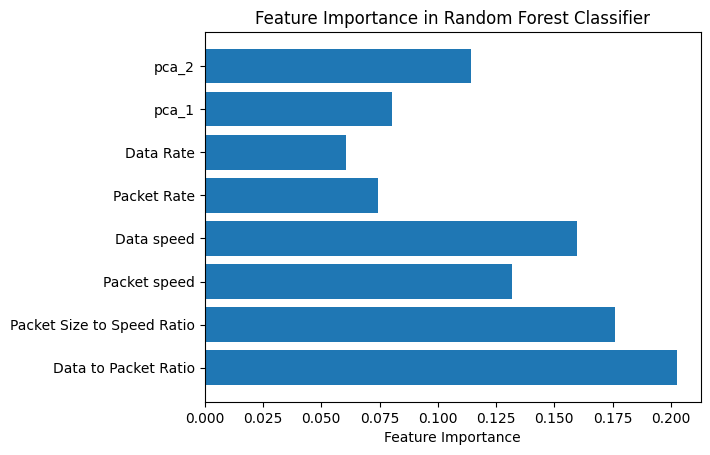

In [40]:
feature_importances = classifier.feature_importances_
plt.barh(feature_cols_2, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

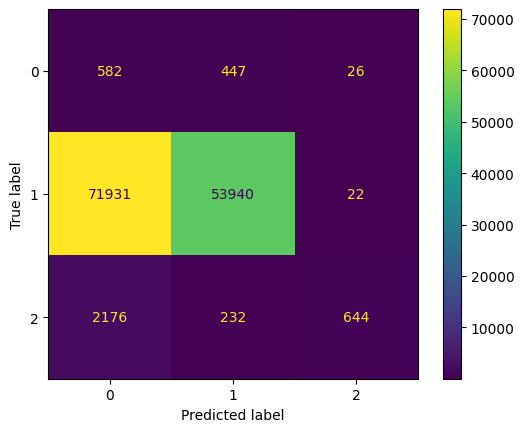

In [41]:
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix)

cm_display.plot()
plt.show()

In [42]:
top_features = ['Data to Packet Ratio', 'Data speed', 'Packet speed', 
                'Packet Size to Speed Ratio', 'pca_1', 'Packet Rate', 'pca_2']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale these features
scaler = StandardScaler()
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

# Train model with just these features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_top_scaled, y_train_encoded)
y_pred = rf_model.predict(X_test_top_scaled)

accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

recall = recall_score(y_test_encoded, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print(conf_matrix)

Accuracy: 42.83%
Recall: 39.74%
[[  565   471    19]
 [71466 54427     0]
 [ 2163   204   685]]


In [43]:
y_train_binary = (y_train_encoded != 0).astype(int)
y_test_binary = (y_test_encoded != 0).astype(int)

# Train binary classifier
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary.fit(X_train_scaled, y_train_binary)
y_pred = rf_binary.predict(X_test_scaled)

accuracy = accuracy_score(y_test_binary, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

recall = recall_score(y_test_binary, y_pred, average="macro")
print(f'Recall: {recall * 100:.2f}%')

conf_matrix = confusion_matrix(y_test_binary, y_pred)
print(conf_matrix)

Accuracy: 42.59%
Recall: 46.90%
[[  541   514]
 [74120 54825]]


# Adathalmaz összehasonlítás

In [44]:
!pip install ydata-profiling
!pip install ipywidgets
from ydata_profiling import ProfileReport
import ipywidgets

In [45]:
training_sample = train_df.sample(frac=0.1, random_state=42)
val_sample = val_df.sample(frac=0.1, random_state=42)

In [46]:
report1 = ProfileReport(training_sample, title = "Training data")
report2 = ProfileReport(val_sample, title = "Validation data")
comparison_report = report1.compare(report2)
comparison_report.to_file("comp_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 35/35 [00:00<00:00, 87.73it/s]
/opt/conda/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6 4 8 ... 7 3 6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
/opt/conda/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6 0 3 ... 3 4 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
/opt/conda/lib/python3.10/site-packages/ydata_profiling/model/correlations.py:87: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 35/35 [00:00<00:00, 116.31it/s]A
/opt/conda/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9 6 9 ... 9 2 6]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
/opt/conda/lib/python3.10/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 8 ... 8 6 8]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]